In [1]:
### Initialization 
import os
import subprocess
print('Working directory: ', os.getcwd())
import geomstats.backend as gs
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import geomstats.visualization as visualization
### Geometry
import geomstats.geometry.spd_matrices as spd
### Move to tangent space
from geomstats.learning.preprocessing import ToTangentSpace
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
### Data
import geomstats.datasets.utils as data_utils
from sklearn.model_selection import GridSearchCV
import numpy as np

gs.random.seed(2020)
visualization.tutorial_matplotlib()

Working directory:  /home/amanolache/Desktop/STAI/SpecialTopicsInAI


INFO: Using numpy backend


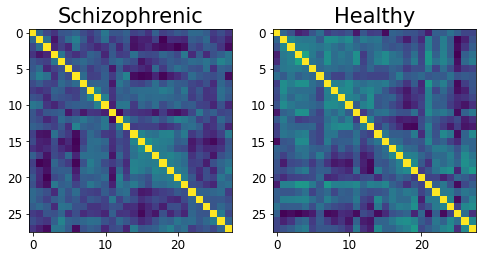

(86, 378)


In [2]:
data, patient_ids, labels = data_utils.load_connectomes()
labels_str = ['Healthy', 'Schizophrenic']

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
imgplot = ax.imshow(data[0])
ax.set_title(labels_str[labels[0]])
ax = fig.add_subplot(122)
imgplot = ax.imshow(data[1])
ax.set_title(labels_str[labels[1]])

plt.show()

flat_data, _, _ = data_utils.load_connectomes(as_vectors=True)
print(flat_data.shape)

In [3]:
manifold = spd.SPDMatrices(28)
ai_metric = spd.SPDMetricAffine(28)
le_metric = spd.SPDMetricLogEuclidean(28)
print(gs.all(manifold.belongs(data)))

True


#### Am modificat logica de evaluare, iar acum vom cauta hiperparametri cu Cross-Validare pentru fiecare metrica in cazul in care lucram pe varietate, si pentru cazul in care lucram in spatiul Euclidian.

#### De asemenea, introducem inca doua modele: SVM si Random Forest.

##### Obiectivul pentru CV e schimbat in ROC-AUC, care e mai robust la dezechilibrul intre clase. 

##### Rezultatele sunt mult mai apropriate dupa ce cautam hiperparametri, iar in unele cazuri sunt chiar mai bune decat pe spatiul Euclidian!

In [4]:
def make_pipeline_and_exp_logreg(scoring='roc_auc'):
    print(f'Scoring: {scoring}')
    grid = {
        "classifier__C": [0.001, 0.01, 0.1, 1, 2, 10, 100], 
        "classifier__penalty": ["none","l2"],
        "classifier__fit_intercept": [True, False],
        "classifier__max_iter" : [1000]
    }

    for nume, pipeline, ds in zip(
        ['AI', 'LE', 'Euclid'],
        [
            Pipeline(steps=[('feature_ext', ToTangentSpace(geometry=ai_metric)),('classifier', LogisticRegression())]),
            Pipeline(steps=[('feature_ext', ToTangentSpace(geometry=le_metric)),('classifier', LogisticRegression())]),
            Pipeline(steps=[('classifier', LogisticRegression())])
        ],
        [data, data, flat_data]
    ):
    
        print(f'{nume} Metric')
        search = GridSearchCV(pipeline, grid, n_jobs=-1, scoring=scoring)
        search.fit(ds, labels)
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        print('-' * 20)
make_pipeline_and_exp_logreg()

Scoring: roc_auc
AI Metric
Best parameter (CV score=0.787):
{'classifier__C': 1, 'classifier__fit_intercept': True, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2'}
--------------------
LE Metric
Best parameter (CV score=0.783):
{'classifier__C': 1, 'classifier__fit_intercept': True, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2'}
--------------------
Euclid Metric
Best parameter (CV score=0.784):
{'classifier__C': 2, 'classifier__fit_intercept': True, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2'}
--------------------


In [5]:
from sklearn.svm import SVC
def make_pipeline_and_exp_svm(scoring='roc_auc'):
    print(f'Scoring: {scoring}')
    grid = {
        'classifier__C': [0.1, 1, 10, 100, 1000], 
        'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto'],
        'classifier__kernel': ['rbf', 'linear', 'poly']} 

    for nume, pipeline, ds in zip(
        ['AI', 'LE', 'Euclid'],
        [
            Pipeline(steps=[('feature_ext', ToTangentSpace(geometry=ai_metric)),('classifier', SVC())]),
            Pipeline(steps=[('feature_ext', ToTangentSpace(geometry=le_metric)),('classifier', SVC())]),
            Pipeline(steps=[('classifier', SVC())])
        ],
        [data, data, flat_data]
    ):
    
        print(f'{nume} Metric')
        search = GridSearchCV(pipeline, grid, n_jobs=-1, scoring=scoring)
        search.fit(ds, labels)
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        print('-' * 20)
make_pipeline_and_exp_svm()

Scoring: roc_auc
AI Metric
Best parameter (CV score=0.809):
{'classifier__C': 10, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
--------------------
LE Metric
Best parameter (CV score=0.812):
{'classifier__C': 10, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
--------------------
Euclid Metric
Best parameter (CV score=0.815):
{'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
--------------------


In [6]:
from sklearn.ensemble import RandomForestClassifier
def make_pipeline_and_exp_rf(scoring='roc_auc'):
    print(f'Scoring: {scoring}')
    grid = {
        'classifier__bootstrap': [True],
        'classifier__max_depth': [80, 90, 100, 110],
        'classifier__max_features': [2, 3],
        'classifier__min_samples_leaf': [3, 4, 5],
        'classifier__min_samples_split': [8, 10, 12],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__n_jobs': [-1]
    }

    for nume, pipeline, ds in zip(
        ['AI', 'LE', 'Euclid'],
        [
            Pipeline(steps=[('feature_ext', ToTangentSpace(geometry=ai_metric)),('classifier', RandomForestClassifier())]),
            Pipeline(steps=[('feature_ext', ToTangentSpace(geometry=le_metric)),('classifier', RandomForestClassifier())]),
            Pipeline(steps=[('classifier', RandomForestClassifier())])
        ],
        [data, data, flat_data]
    ):
    
        print(f'{nume} Metric')
        search = GridSearchCV(pipeline, grid, n_jobs=-1, scoring=scoring)
        search.fit(ds, labels)
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        print('-' * 20)
make_pipeline_and_exp_rf()

Scoring: roc_auc
AI Metric
Best parameter (CV score=0.808):
{'classifier__bootstrap': True, 'classifier__max_depth': 100, 'classifier__max_features': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 300, 'classifier__n_jobs': -1}
--------------------
LE Metric
Best parameter (CV score=0.827):
{'classifier__bootstrap': True, 'classifier__max_depth': 90, 'classifier__max_features': 2, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 12, 'classifier__n_estimators': 300, 'classifier__n_jobs': -1}
--------------------
Euclid Metric
Best parameter (CV score=0.799):
{'classifier__bootstrap': True, 'classifier__max_depth': 110, 'classifier__max_features': 3, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 12, 'classifier__n_estimators': 200, 'classifier__n_jobs': -1}
--------------------


#### Implementam kernel-ul de la https://ieeexplore.ieee.org/document/6247965 .
#### Kernelul ne ajuta sa proiectam datele pe varietatea matricelor SPD si sa optimizam modelul pe spatiul tangent, tinand cont de metrica Log-Euclidiana.
#### Operatiile ar trebui sa fie echivalente cu folosirea unui kernel liniar impreuna cu proiectia pe spatiul tangent si folosirea metricii LE, dar in practica, SVM-ul ce foloseste kernel-ul implementat are rezultate mai bune.

##### O observatie interesanta e faptul ca daca proiectam datele de  pe varietate pe spatiul tangent si folosim un kernel rbf care proiecteaza la randul lui datele intr-un spatiu infinit dimensional, rezultatele sunt considerabil mai bune.

In [8]:
from sklearn.svm import SVC

# CVDL Kernel implemented as seen at:
# https://ieeexplore.ieee.org/document/6247965

from scipy.linalg import logm
def cvdl_kernel(X, Y):
    log_x = logm(X)
    log_y = logm(Y)
    res = np.trace(np.dot(log_x, log_y))
    return res

def proxy_kernel(X, Y, K=cvdl_kernel):
    """Another function to return the gram_matrix,
    which is needed in SVC's kernel or fit
    This is a technical quirk and you need to use 
    a proxy kernel or construct the gram matrix by hand
    
    Explanation: 
    https://stackoverflow.com/questions/43994505/i-am-trying-to-implement-svm-in-scikit-learn-with-custom-rbf-kernel-but-it-is-s
    """
    gram_matrix = np.zeros((X.shape[0], Y.shape[0]))
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            gram_matrix[i, j] = K(x, y)
    return gram_matrix



def get_gram_matrix(X1, X2):
    """(Pre)calculates Gram Matrix K for PCA"""
    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            gram_matrix[i, j] = cvdl_kernel(x1, x2)
    return gram_matrix

In [9]:
# {'classifier__C': 10, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}

In [12]:
from sklearn.model_selection import cross_validate
clf = SVC(C=10, gamma=1, kernel=proxy_kernel)
result = cross_validate(clf, data, labels, scoring='roc_auc')
print(result['test_score'].mean())

0.7713888888888889


In [13]:
from sklearn.model_selection import cross_validate

pipeline = Pipeline(steps=[('feature_ext', ToTangentSpace(geometry=le_metric)), ('classifier', SVC(C=10, gamma=1, kernel='linear'))])
result = cross_validate(pipeline, data, labels, scoring='roc_auc')
print(result['test_score'].mean())

0.7294444444444445


In [14]:
from sklearn.decomposition import KernelPCA

#### Folosim KernelPCA pentru a folosi kernel-ul definit anterior cu metoda PCA.
#### Rezultatele cu KernelPCA, Proiectie, si TangentPCA sunt identice, dupa cum ne-am fi asteptat.

In [15]:
data_kernel_gram = get_gram_matrix(data, data)

In [16]:
kpca = KernelPCA(n_components=3, kernel='precomputed', n_jobs=-1)

X_reduced = kpca.fit_transform(data_kernel_gram)
y = labels

<IPython.core.display.Javascript object>


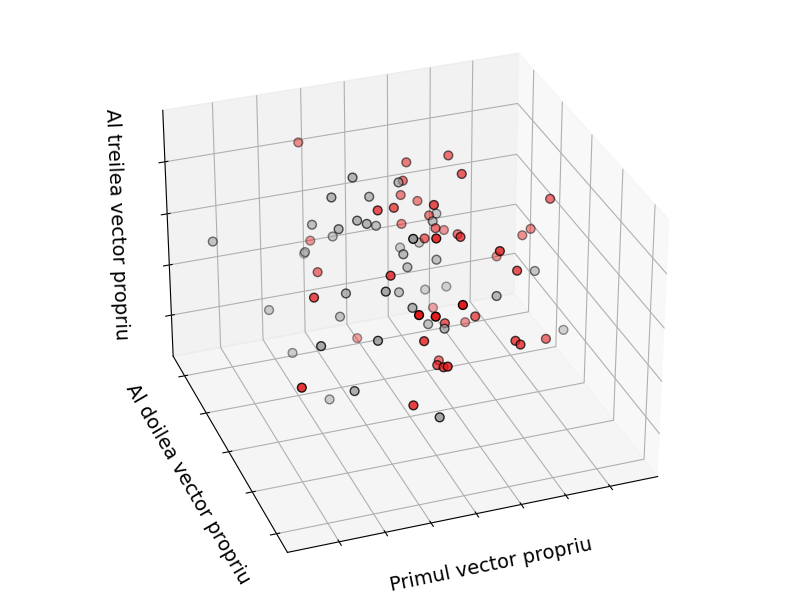

In [22]:
%matplotlib notebook
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel("Primul vector propriu")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Al doilea vector propriu")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Al treilea vector propriu")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [18]:
pipeline = Pipeline(steps=[('feature_ext', ToTangentSpace(geometry=le_metric)), ('pca', KernelPCA(n_components=3, kernel='linear', n_jobs=-1))])
X_reduced = pipeline.fit_transform(data)
y = labels

<IPython.core.display.Javascript object>


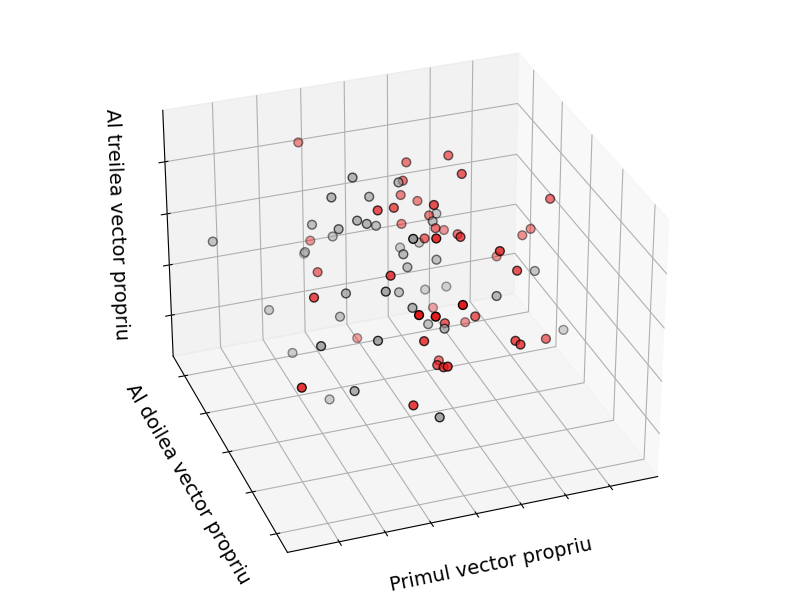

In [19]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel("Primul vector propriu")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Al doilea vector propriu")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Al treilea vector propriu")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [20]:
from geomstats.learning.pca import TangentPCA
from geomstats.learning.frechet_mean import FrechetMean

mean = FrechetMean(metric=le_metric)

mean.fit(data)

mean_estimate = mean.estimate_

In [21]:
tpca = TangentPCA(metric=le_metric, n_components=3)
tpca = tpca.fit(data, base_point=mean_estimate)
X_reduced = tpca.transform(data)

<IPython.core.display.Javascript object>


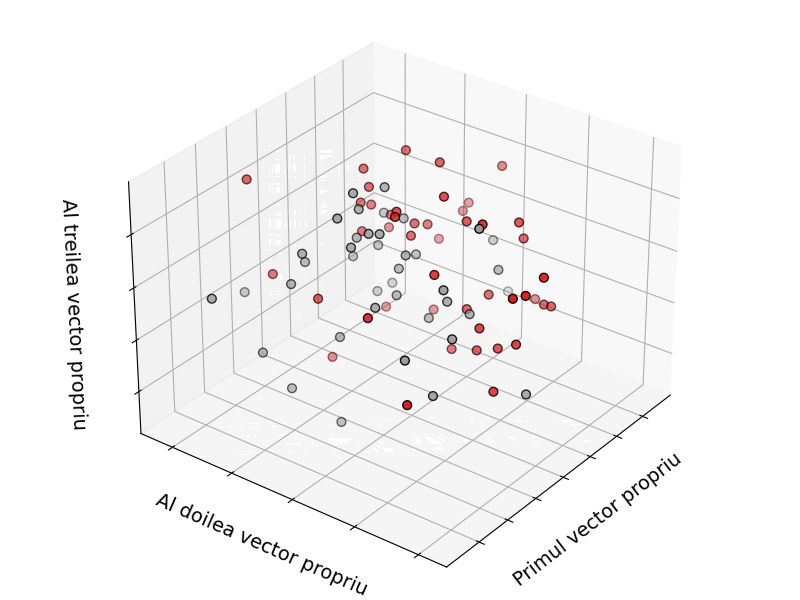

In [19]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel("Primul vector propriu")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Al doilea vector propriu")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Al treilea vector propriu")
ax.w_zaxis.set_ticklabels([])

plt.show()

#### Incercam sa invatam o varietate 3D cu t-SNE, folosind datele in spatiul Euclidian

<IPython.core.display.Javascript object>


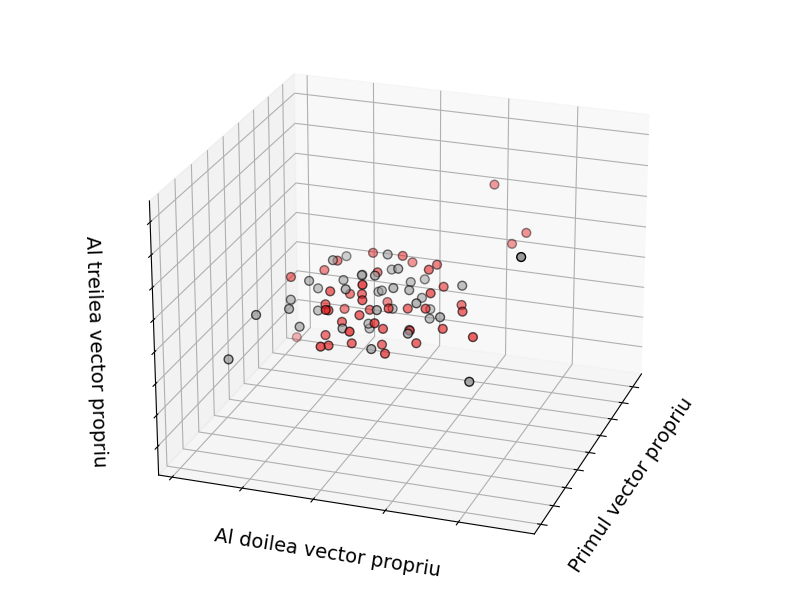

In [11]:
%matplotlib notebook
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, n_jobs=-1)

X_reduced = tsne.fit_transform(flat_data)
y = labels


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel("Primul vector propriu")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Al doilea vector propriu")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Al treilea vector propriu")
ax.w_zaxis.set_ticklabels([])

plt.show()